In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from rich.progress import track
from rich import progress
import IPython

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.visualization import plot_beamline

In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{( task.speed or 0 ):.1f}/s"
        else:
            return f"{( 1 / task.speed or 0):.1f} s/i"

In [4]:
n_trajectories = 3_000_000
options = PropagationOptions(verbose=False, n_cores=8)
gravity = Gravity(0, -9.81, 0)
particle = TlF()

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3

## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture width | 8 mm |
| rc aperture height | 6 mm | 

In [5]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        # RectangularAperture(
        #     x=0,
        #     y=0,
        #     z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
        #     wx=rc_aperture_width,
        #     wy=rc_aperture_height,
        # )
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=0.011,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[
        # CircularAperture(0, 0, bbexit.stop + 19.6 * in_to_m, R * 1.2),
        # CircularAperture(
        #     0,
        #     0,
        #     bbexit.stop + (19.6 + 0.375 + 9.625) * in_to_m,
        #     R * 1.2,
        # ),
    ],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = ElectrostaticQuadrupoleLens(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)

In [6]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

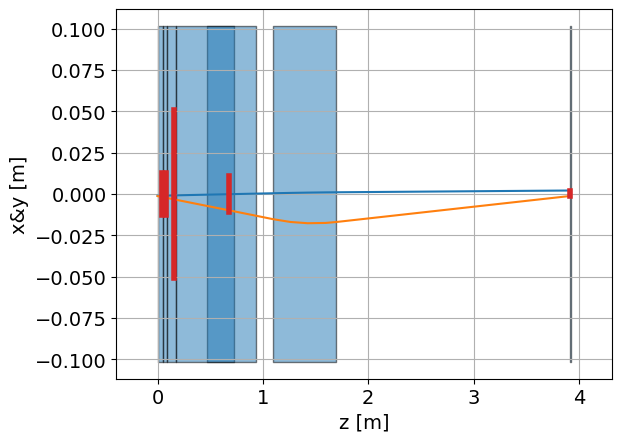

In [7]:
traj = trajectories[list(trajectories.keys())[0]]

fig, ax = plt.subplots()
ax.plot(traj.z, traj.x)
ax.plot(traj.z, traj.y)

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x&y [m]")

ax.grid(True)

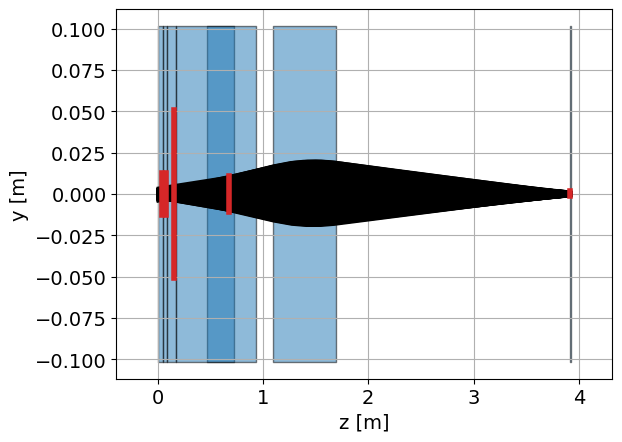

In [8]:
fig, ax = plt.subplots()
for traj in trajectories.values():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

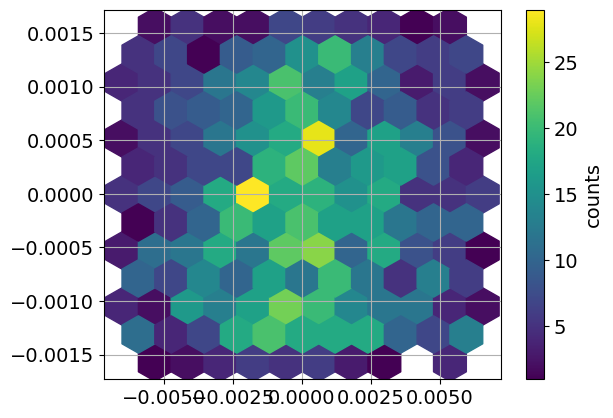

In [9]:
x, y = np.array([(traj.x[-1], traj.y[-1]) for traj in trajectories.values()]).T

fig, ax = plt.subplots()

hb = ax.hexbin(x, y, gridsize=11, mincnt=1, marginals=False)

cbar = fig.colorbar(hb, ax=ax, label="counts")

ax.grid(True)

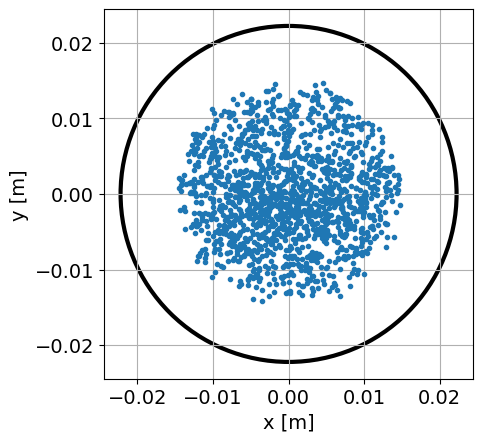

In [10]:
xs = [traj.x[5] for traj in trajectories.values()]
ys = [traj.y[5] for traj in trajectories.values()]

fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0, 0), 1.75 / 2 * in_to_m, fill=False, lw=3))
ax.plot(xs, ys, ".")

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect(1)
ax.grid(True)

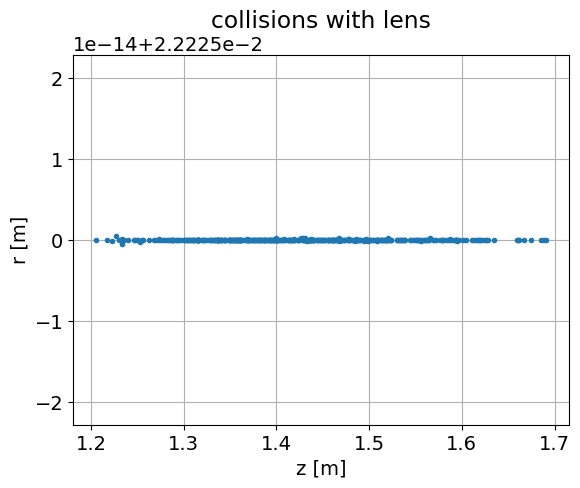

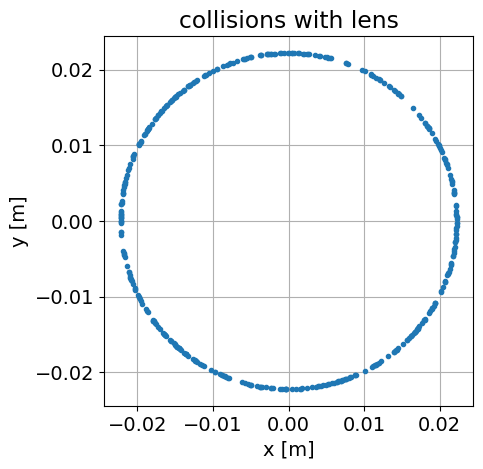

In [19]:
x, v = section_data[5].saved_collisions[1]

fig, ax = plt.subplots()
ax.plot(x.z, np.sqrt(x.x**2 + x.y**2), ".")
ax.set_xlabel("z [m]")
ax.set_ylabel("r [m]")
ax.set_title("collisions with lens")
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(x.x, x.y, ".")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("collisions with lens")
ax.set_aspect(1.0)
ax.grid(True)


## Scan Lens Voltage

In [ ]:
def lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    voltage: float,
    detection_distance: float,
    length: float = 0.6,
    radius: float = 0.022225,
):
    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=lens_electrode_length,
                radius=radius,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2
        + length,
        V=voltage,
        R=radius,
        save_collisions=False,
    )
    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + detection_distance + 0.001,
                wx,
                wy,
            )
        ],
        start=eql.stop + detection_distance,
        stop=eql.stop + detection_distance + 1e-2,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [ ]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

voltages = np.linspace(0, 30e3, 7)

data = []
for voltage in track(voltages):
    data.append(
        lens_scan_function(
            origin,
            velocities,
            voltage,
            detection_distance=lens_reducer_flange
            + 1 * nipple_length
            + distance_det_center,
        )
    )

Output()

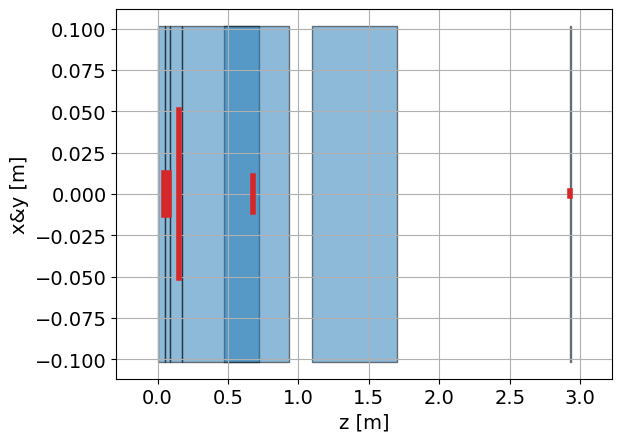

In [ ]:
traj = trajectories[list(trajectories.keys())[0]]

fig, ax = plt.subplots()

plot_beamline(data[0][2], ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x&y [m]")

ax.grid(True)

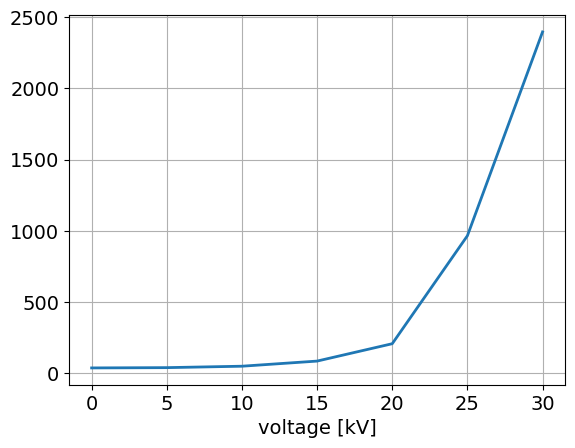

In [ ]:
survived = [dat[0][-1].survived for dat in data]
fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived, lw=2)

ax.set_xlabel("voltage [kV]")
ax.grid(True)

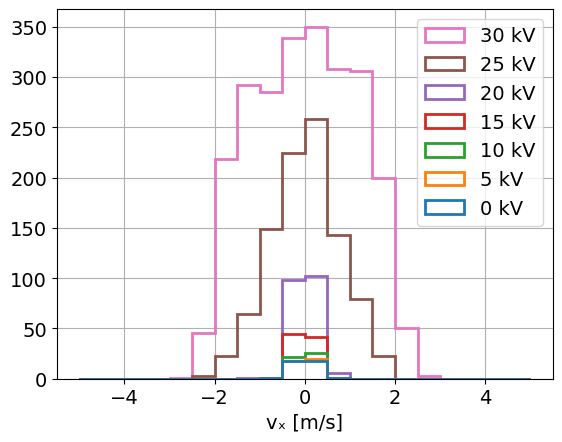

In [ ]:
vxs = [[traj.vx[-1] for traj in dat[1].values()] for dat in data]
bins = np.linspace(-5, 5, 21)
labels = [f"{voltage/1e3:.0f} kV" for voltage in voltages]

fig, ax = plt.subplots()
ax.hist(vxs, bins=bins, histtype="step", lw=2, density=False, label=labels)

ax.set_xlabel("vₓ [m/s]")
ax.legend()
ax.grid(True)

## Scan Lens Voltage and Detection Distance

### Without EQL
For referencing gain, taking into account that the gain should be calculated as if the lens is not there, e.g. the beamline is shorter

In [ ]:
def no_lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    detection_distance: float,
):
    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                bbexit.stop + distance_lens_bbexit + detection_distance + 0.001,
                wx,
                wy,
            )
        ],
        start=bbexit.stop + distance_lens_bbexit + detection_distance,
        stop=bbexit.stop + distance_lens_bbexit + detection_distance + 1e-2,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [ ]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

nr_nipples = 4
distances = (
    lens_reducer_flange
    + np.arange(nr_nipples + 1) * nipple_length
    + distance_det_center
)

data_no_lens = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("distance", total=len(distances))
    for idd, distance in enumerate(distances):
        dat = no_lens_scan_function(origin, velocities, detection_distance=distance)
        pb.update(task_id=t1, completed=idd + 1)
        data_no_lens.append((distance, [dat]))
    pb.refresh()

Output()

### With EQL

In [ ]:
nr_nipples = 4
distances = (
    lens_reducer_flange
    + np.arange(nr_nipples + 1) * nipple_length
    + distance_det_center
)
voltages = np.linspace(0, 30e3, 25)

data = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("distance", total=len(distances))
    t2 = pb.add_task("voltage", total=len(voltages))
    for idd, distance in enumerate(distances):
        dat = []
        for idv, voltage in enumerate(voltages):
            dat.append(
                lens_scan_function(
                    origin, velocities, voltage, detection_distance=distance
                )
            )
            pb.update(task_id=t2, completed=idv + 1)
        if idd < len(distances) - 1:
            pb.reset(t2)
        pb.update(task_id=t1, completed=idd + 1)
        data.append((distance, dat))
    pb.refresh()

Output()

### Total Gain

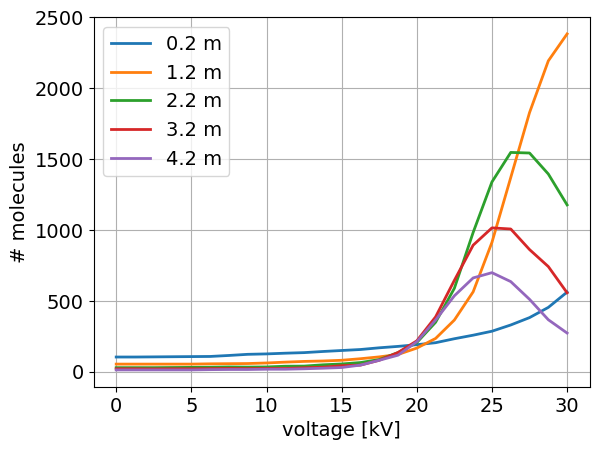

In [ ]:
survived = np.array([[d[0][-1].survived for d in dat[1]] for dat in data])
survived_no_lens = np.array(
    [[d[0][-1].survived for d in dat[1]] for dat in data_no_lens]
).flatten()

labels = [f"{dist:.1f} m" for dist in distances]

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T, lw=2, label=labels[: len(survived)])

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules")
ax.legend()
ax.grid(True)

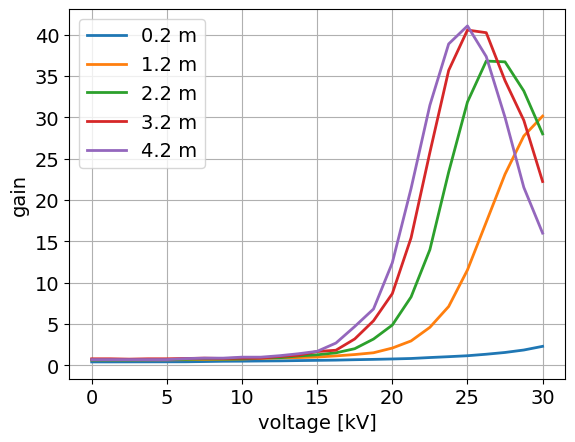

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3, survived.T / survived_no_lens, lw=2, label=labels[: len(survived)]
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

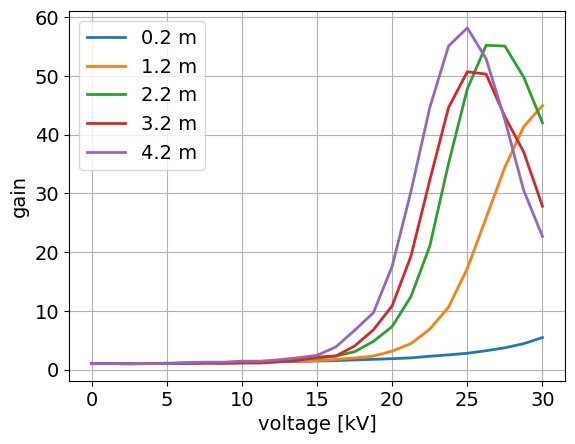

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3, survived.T / survived[:, 0], lw=2, label=labels[: len(survived)]
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)